# XGBoost proposed model

The purpose of this notebook is to present our choosen model. We tried to finetune our model on a fixed validation set using the SITE_ID split test hoping in better performances, but we weren't able to achieve them. 

We didn't apply cross-validation using the SITE_ID split criteria because this would have led to unbalanced targets in the folds. This could have led to having zero positive targets in the fold, thus making impossible to compute metrics such as precision and recall on that folder.

In [114]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from numpy import argmax

import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('..')


In [ ]:
from helper import data_container

# Support functions

In [115]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,25))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    

def plot_roc_curve(y, predictions, ax):
    fpr, tpr, thresholds = roc_curve(y, predictions)
    ax.plot([0,1], [0,1], linestyle='--', label='xgboost')
    ax.plot(fpr, tpr, marker='.', label='Logistic')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    ax.plot()

def plot_precision_recall_curve(y, predictions, ax):
    precision, recall, thresholds = precision_recall_curve(y, predictions)
    no_skill = len(y[y==1]) / len(y)
    ax.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    ax.plot(recall, precision, marker='.', label='xgboost')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.legend()
    ax.plot()

    
rectifier = lambda x, thr: 0 if x < thr else 1

In [116]:
# Model parameters
MAX_TREE_DEPTH = 8
TREE_METHOD = 'gpu_hist' ##train on gpu is considerably faster 
ITERATIONS = 1000 #num_boost_round
SUBSAMPLE = 0.6
REGULARIZATION = 0.1
GAMMA = 2
POS_WEIGHT = 1
EARLY_STOP = 10




# Dataset preparation

In [117]:
train = pd.read_csv('../dataset/train.csv')
container = data_container(train, drop=False)

In [118]:
## split in train and test
train_df = container.compute_14d_features()

next_col=[col for col in train_df.columns if 'next' in col and not 'aircon' in col]
aircon_sum_prev = ['aircon_sum_wo_prev14d', 'mean_temperature_prev14d']

to_drop = next_col + aircon_sum_prev + ['ge_min_persistance_prev14d', 'ge_mean_persistance_prev14d'] +['year']

train_df = train_df.drop(columns=to_drop)
train_final_model = train_df.copy()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)






In [119]:
np.random.seed(seed=321)

SITE_ID  = train_df['SITE_ID'].unique()

np.random.shuffle(SITE_ID)

oldout_ID = [x for x in SITE_ID if np.random.uniform(0, 1) < 0.2]

oldout_set =  train_df[train_df['SITE_ID'].isin(oldout_ID)]
print(len(oldout_set['SITE_ID'].unique()))

train_df = train_df[~train_df['SITE_ID'].isin(oldout_ID)]
print(len(train_df['SITE_ID'].unique()))

409
1662


In [120]:
y_train = train_df['aircon_sum_target_next14d']
X_train = train_df.drop(columns=['SITE_ID', 'DATE', 'aircon_sum_target_next14d'])
y_test = oldout_set[['SITE_ID','DATE','N_TRANSPORTED_SITES','aircon_sum_target_next14d']]
X_test = oldout_set.drop(columns=['aircon_sum_target_next14d', 'DATE', 'SITE_ID'])

In [121]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(498600, 56)
(498600,)
(122700, 56)
(122700, 4)


In [122]:
params = {'tree_method': 'gpu_hist',
          'max_depth': 4,
          'alpha': 0,
          'gamma': 0.5,
          'subsample': 0.6,
          'scale_pos_weight': 180,
          'learning_rate': 0.4, 
          'verbosity': 3, 
          'objective':'binary:logistic',
          'predictor' : 'gpu_predictor',
          'n_estimators' : 7,
          'lambda' : 2,
          
          }

model = xgb.XGBClassifier(**params)


#Learning Rate:  0.4
#Gamma:  0
#Max Depth:  10
#Subsample:  0.6
#Max Features at Split:  0.8
#Alpha:  1
#Lambda:  1
#Minimum Sum of the Instance Weight Hessian to Make a Child:  1
#Number of Trees:  2000
#model = xgb.XGBClassifier(**params)


In [123]:
model.fit(X_train, y_train, eval_metric='aucpr',eval_set=[(X_test, y_test['aircon_sum_target_next14d'])], early_stopping_rounds= 200)
test_predictions = model.predict_proba(X_test)[:, 1]

[16:41:26] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:1167: [GPU Hist]: Configure
[16:41:26] DEBUG: /workspace/src/common/device_helpers.cu:38: Running nccl init on: 9.0
[16:41:26] ======== Monitor: DenseCuts ========
[16:41:26] Init: 0.001012s, 1 calls @ 1012us

[16:41:26] ======== Monitor: HistogramCuts ========
[0]	validation_0-aucpr:0.00956
Will train until validation_0-aucpr hasn't improved in 200 rounds.
[1]	validation_0-aucpr:0.01364
[2]	validation_0-aucpr:0.01519
[3]	validation_0-aucpr:0.01664
[4]	validation_0-aucpr:0.01519
[5]	validation_0-aucpr:0.01584
[6]	validation_0-aucpr:0.01530


# Test prediction

In [124]:
y_test['prediction'] = test_predictions

f1 score:  0.06053268765133172
precision:  0.03863987635239567
recall: 0.13966480446927373
auc precision-recall:  0.016581329162568582


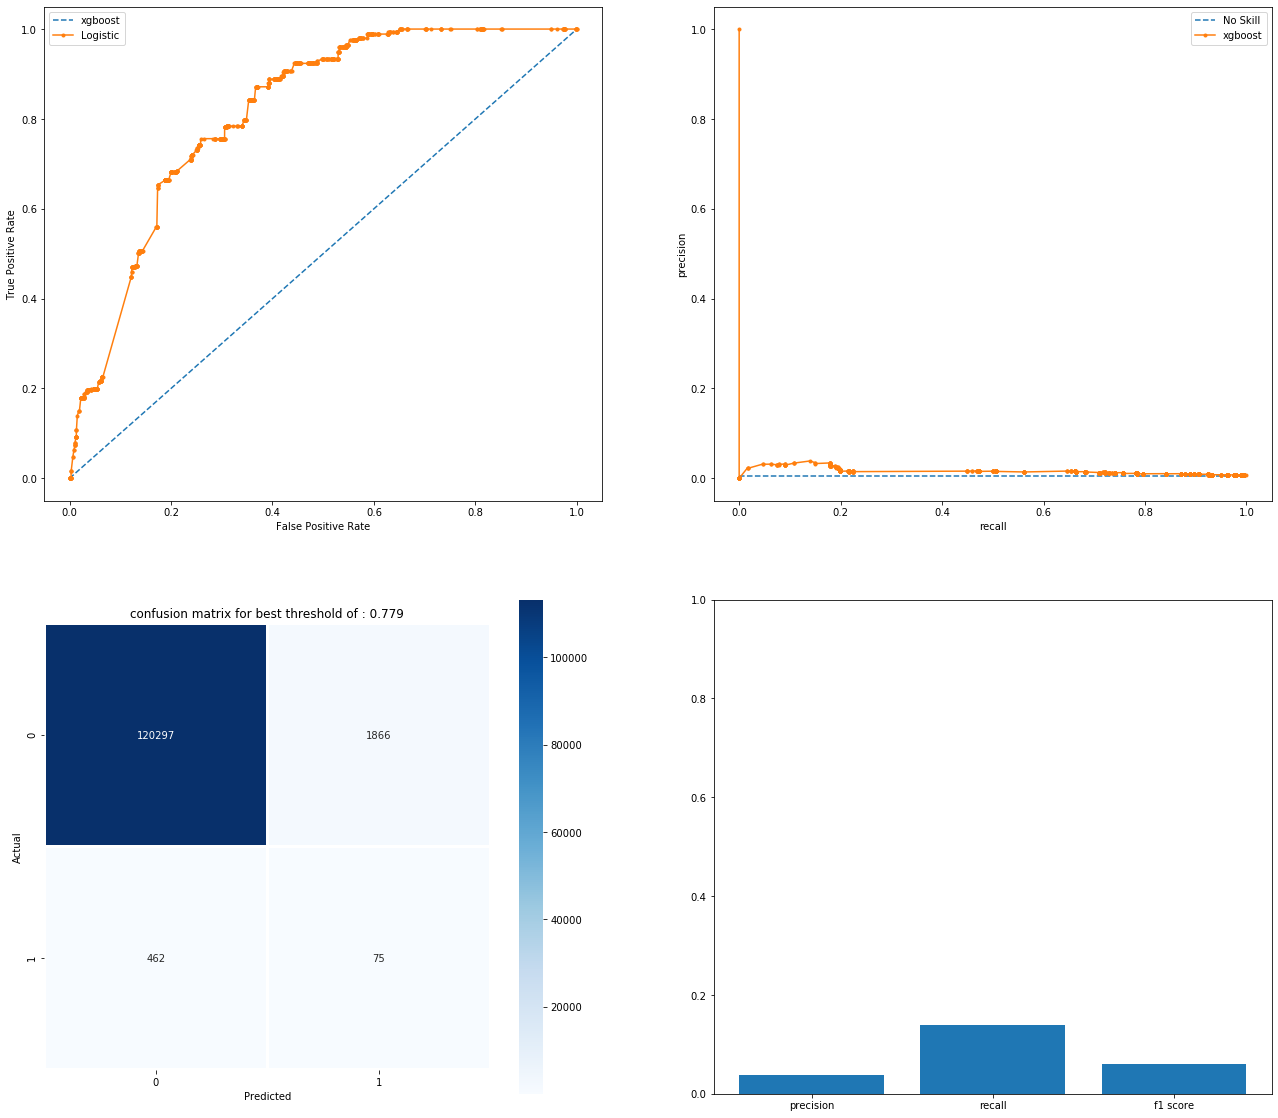

In [125]:
from matplotlib import pyplot as plt

f, axs = f, axs = plt.subplots(figsize= (22,20), ncols=2, nrows=2)
plot_roc_curve(y_test['aircon_sum_target_next14d'], test_predictions, axs[0][0])
precision, recall, thresholds = precision_recall_curve(y_test['aircon_sum_target_next14d'], test_predictions)
plot_precision_recall_curve(y_test['aircon_sum_target_next14d'], test_predictions, axs[0][1])


fscore = (2 * precision * recall) / (precision + recall)
fscore = fscore[~np.isnan(fscore)]
ix = argmax(fscore)
max_fscore = fscore[ix]
best_thr = thresholds[ix]
rectified = np.array([rectifier(x, best_thr) for x in test_predictions])


confusion_matrix = pd.crosstab(y_test['aircon_sum_target_next14d'], rectified, rownames=['Actual'], colnames=['Predicted'])
heatmap_title = 'confusion matrix for best threshold of : {thr:.3f}'
sns.heatmap(confusion_matrix, annot=True, fmt='d', square=True, cmap='Blues',
            ax=axs[1][0], robust=True, linewidth=2).set(title=heatmap_title.format(thr = best_thr));


max_precision = precision[ix]
max_recall = recall[ix]

x_bar = np.arange(3)
y_bar = np.array([max_precision, max_recall, max_fscore])
axs[1,1].set_ylim(0, 1)
axs[1,1].bar(x_bar, y_bar)
axs[1,1].set_xticks([0, 1, 2])
axs[1,1].set_xticklabels(['precision', 'recall', 'f1 score']);


print('f1 score: ', max_fscore)
print('precision: ', max_precision)
print('recall:', max_recall)
print('auc precision-recall: ', auc(recall, precision))

In [126]:
y_test['DATE'] = y_test['DATE'].astype(str)

In [127]:
recalls = []

for date, daily_df in y_test.groupby(['DATE']):
    daily_df=daily_df.copy()
    daily_df['final_prediction'] = 0
    daily_df['NORM_N_TRANSPORTED_SITES' ] = daily_df['N_TRANSPORTED_SITES' ]/daily_df['N_TRANSPORTED_SITES'].max()
    daily_df['weighted_prediction' ] = 0.8* daily_df['prediction' ] + 0.2*daily_df['NORM_N_TRANSPORTED_SITES']
    daily_df = daily_df.sort_values(by=['weighted_prediction' ], ascending=False)
    daily_df = daily_df.reset_index(drop=True)
    daily_df.loc[0:10, 'final_prediction' ] = 1
    daily_recall = recall_score(y_true=daily_df['aircon_sum_target_next14d' ], y_pred=daily_df['final_prediction' ])
    recalls.append(daily_recall)
final_metric= np.mean(recalls)
print(final_metric)




0.10276190476190476


# Final model train and prediction of submission

In [128]:
test_container = data_container(pd.read_csv('/kaggle/input/dmtm-dataset/test.csv'), drop=False)

In [129]:
X = train_final_model.drop(columns=['SITE_ID', 'DATE', 'aircon_sum_target_next14d'])
y = train_final_model['aircon_sum_target_next14d']

print(X.columns)

xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X, y)

Index(['N_TRANSPORTED_SITES', 'GEOGRAPHIC_CLUSTER_K_0',
       'GEOGRAPHIC_CLUSTER_K_1', 'GEOGRAPHIC_CLUSTER_K_2',
       'GEOGRAPHIC_CLUSTER_K_3', 'GEOGRAPHIC_CLUSTER_K_4',
       'GEOGRAPHIC_CLUSTER_K_5', 'GEOGRAPHIC_CLUSTER_K_6',
       'GEOGRAPHIC_CLUSTER_K_7', 'GEOGRAPHIC_CLUSTER_K_8',
       'GEOGRAPHIC_CLUSTER_K_9', 'equipment_sum_alarms_prev14d',
       'fire/smoke_sum_alarms_prev14d', 'ge_sum_alarms_prev14d',
       'power_sum_alarms_prev14d', 'temperature_sum_alarms_prev14d',
       'skew_equipment_alarms_prev14d', 'skew_fire/smoke_alarms_prev14d',
       'skew_ge_alarms_prev14d', 'skew_power_alarms_prev14d',
       'skew_temperature_alarms_prev14d', 'kurt_equipment_alarms_prev14d',
       'kurt_fire/smoke_alarms_prev14d', 'kurt_ge_alarms_prev14d',
       'kurt_power_alarms_prev14d', 'kurt_temperature_alarms_prev14d',
       'max_temperature_prev14d', 'min_temperature_prev14d',
       'max_rain_mm_prev14d', 'min_rain_mm_prev14d', 'mean_rain_mm_prev14d',
       'max_humidity_p

XGBClassifier(alpha=0, base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=0,
              importance_type='gain', interaction_constraints=None, lambda=2,
              learning_rate=0.4, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=7, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=2, scale_pos_weight=180,
              subsample=0.6, tree_method='gpu_hist', validate_parameters=False,
              verbosity=3)

In [130]:

test = test_container.compute_14d_features()
submission = test[['SITE_ID', 'DATE']]
test = test.drop(columns=to_drop)


In [131]:
submission['prediction'] = xgb_model.predict_proba(test.drop(columns=['SITE_ID', 'DATE']))[:,1]

submission.to_csv('submission.csv', index=False)

In [132]:
submission.head(5)

,SITE_ID,DATE,prediction
0,858,2019-04-10,0.372249
1,858,2019-04-11,0.570206
2,858,2019-04-12,0.504844
3,858,2019-04-13,0.504844
4,858,2019-04-14,0.504844
